# Important Links

GAN for Face Generator: https://github.com/AshishJangra27/Face-Generator-with-GAN

Gender Style Transfer: https://github.com/AshishJangra27/Gender-Style-Transfer

Gender Classifier: https://github.com/AshishJangra27/Gender-Classifier

LinkedIn: https://www.linkedin.com/in/ashish-jangra/

Assignment:

- Load the pretrainde Generator
- Load Gender Vector
- Generate 10 variations of the image from male to female as per gender vector

In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pickle
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [21]:
## 2. Define Generator Architecture (DCGAN)
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        """
        DCGAN Generator
        nz: size of latent vector
        ngf: number of generator feature maps
        nc: number of channels (3 for RGB)
        """
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # state size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [24]:
import tensorflow as tf
from tensorflow import keras

generator = keras.models.load_model('/content/generator_700.h5')
print('Generator model loaded successfully!')


Generator model loaded successfully!


In [25]:
## 4. Gender Vector Creation Functions
def create_gender_vector(generator, device, num_samples=1000):
    """
    Create gender vector by analyzing latent space directions
    This is a simplified approach - in practice, you'd use labeled data
    """
    generator.eval()

    # Generate random latent vectors
    with torch.no_grad():
        z_samples = torch.randn(num_samples, nz, 1, 1, device=device)

        # For this demo, we'll create synthetic gender directions
        # In practice, you'd use a trained gender classifier

        # Create male and female direction vectors (simplified)
        male_direction = torch.randn(nz, device=device)
        female_direction = -male_direction  # Opposite direction

        # Normalize vectors
        male_direction = male_direction / torch.norm(male_direction)
        female_direction = female_direction / torch.norm(female_direction)

    return male_direction, female_direction

def interpolate_vectors(vec1, vec2, num_steps=10):
    """
    Linear interpolation between two vectors
    """
    interpolated = []
    for i in range(num_steps):
        alpha = i / (num_steps - 1)
        interpolated_vec = (1 - alpha) * vec1 + alpha * vec2
        interpolated.append(interpolated_vec)

    return torch.stack(interpolated)

In [26]:
## 5. Gender Classifier (MobileNet-based)
import torchvision.models as models

class GenderClassifier(nn.Module):
    def __init__(self):
        super(GenderClassifier, self).__init__()
        # Use MobileNetV2 as backbone
        self.backbone = models.mobilenet_v2(pretrained=True)
        # Modify classifier for binary gender classification
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.backbone.last_channel, 2)  # 2 classes: male, female
        )

    def forward(self, x):
        return self.backbone(x)

# Initialize gender classifier
gender_classifier = GenderClassifier().to(device)

# For demo purposes, we'll use random weights
# In practice, you'd load pretrained gender classifier weights
print('Gender classifier initialized!')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 

Gender classifier initialized!


In [27]:
def create_advanced_gender_vector(generator, gender_classifier, device, num_samples=500):
    """
    Create gender vector using generated images and gender classifier
    """
    generator.eval()
    gender_classifier.eval()

    male_vectors = []
    female_vectors = []

    # Image preprocessing for gender classifier
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    with torch.no_grad():
        for _ in range(num_samples):
            # Generate random latent vector
            z = torch.randn(1, nz, 1, 1, device=device)

            # Generate image
            fake_img = generator(z)

            # Preprocess for gender classifier
            processed_img = preprocess(fake_img.squeeze(0))
            processed_img = processed_img.unsqueeze(0)

            # Classify gender (0: male, 1: female)
            gender_pred = torch.softmax(gender_classifier(processed_img), dim=1)
            predicted_gender = torch.argmax(gender_pred, dim=1).item()

            # Collect vectors based on predicted gender
            if predicted_gender == 0:  # Male
                male_vectors.append(z.squeeze().cpu())
            else:  # Female
                female_vectors.append(z.squeeze().cpu())

    # Calculate mean vectors
    if len(male_vectors) > 0 and len(female_vectors) > 0:
        mean_male = torch.stack(male_vectors).mean(dim=0).to(device)
        mean_female = torch.stack(female_vectors).mean(dim=0).to(device)

        # Calculate gender direction
        gender_direction = mean_female - mean_male
        gender_direction = gender_direction / torch.norm(gender_direction)

        return mean_male, mean_female, gender_direction
    else:
        # Fallback to random directions
        print('Using fallback random directions')
        male_dir = torch.randn(nz, device=device)
        female_dir = -male_dir
        gender_dir = female_dir - male_dir
        return male_dir, female_dir, gender_dir / torch.norm(gender_dir)

In [28]:
## 7. Generate Gender Transition Images
def generate_gender_transition(generator, base_vector, gender_direction,
                             num_variations=10, alpha_range=(-3, 3)):
    """
    Generate face variations from male to female

    Args:
        generator: Trained generator model
        base_vector: Base latent vector
        gender_direction: Gender direction vector
        num_variations: Number of variations to generate
        alpha_range: Range of alpha values for interpolation
    """
    generator.eval()

    generated_images = []
    alpha_values = np.linspace(alpha_range[0], alpha_range[1], num_variations)

    with torch.no_grad():
        for alpha in alpha_values:
            # Modify base vector in gender direction
            modified_vector = base_vector + alpha * gender_direction
            modified_vector = modified_vector.view(1, nz, 1, 1)

            # Generate image
            generated_img = generator(modified_vector)

            # Convert to numpy and denormalize
            img_np = generated_img.squeeze(0).cpu().numpy()
            img_np = (img_np + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
            img_np = np.transpose(img_np, (1, 2, 0))

            generated_images.append(img_np)

    return generated_images, alpha_values

In [29]:
## 8. Visualization Functions
def plot_gender_transition(images, alpha_values, title='Gender Transition: Male to Female'):
    """
    Plot the gender transition images
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, (img, alpha) in enumerate(zip(images, alpha_values)):
        axes[i].imshow(img)
        axes[i].set_title(f'α = {alpha:.2f}', fontsize=12)
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def save_transition_images(images, alpha_values, save_dir='gender_transition'):
    """
    Save transition images to disk
    """
    os.makedirs(save_dir, exist_ok=True)

    for i, (img, alpha) in enumerate(zip(images, alpha_values)):
        # Convert to PIL Image and save
        img_pil = Image.fromarray((img * 255).astype(np.uint8))
        img_pil.save(f'{save_dir}/transition_{i:02d}_alpha_{alpha:.2f}.png')

    print(f'Saved {len(images)} images to {save_dir}/')

Generator model loaded successfully!
Generator input shape: (None, 100)
Generator output shape: (None, 128, 128, 3)
Gender classifier created!
Starting TensorFlow/Keras Gender Transition...
METHOD 1: Advanced Gender Vector Approach
----------------------------------------
Creating gender vectors...
Creating gender vectors using TensorFlow...
Generator input shape: (100,)
Processing sample 0/50
Processing sample 20/50
Processing sample 40/50
Using fallback random directions
Gender vector creation completed!
Male vector shape: (100,)
Female vector shape: (100,)
Gender direction shape: (100,)

Generating gender transition images...
Generating transition images...
Generating image 1/10 (α=-2.00)
Generating image 2/10 (α=-1.56)
Generating image 3/10 (α=-1.11)
Generating image 4/10 (α=-0.67)
Generating image 5/10 (α=-0.22)
Generating image 6/10 (α=0.22)
Generating image 7/10 (α=0.67)
Generating image 8/10 (α=1.11)
Generating image 9/10 (α=1.56)
Generating image 10/10 (α=2.00)
Generated 10 tr

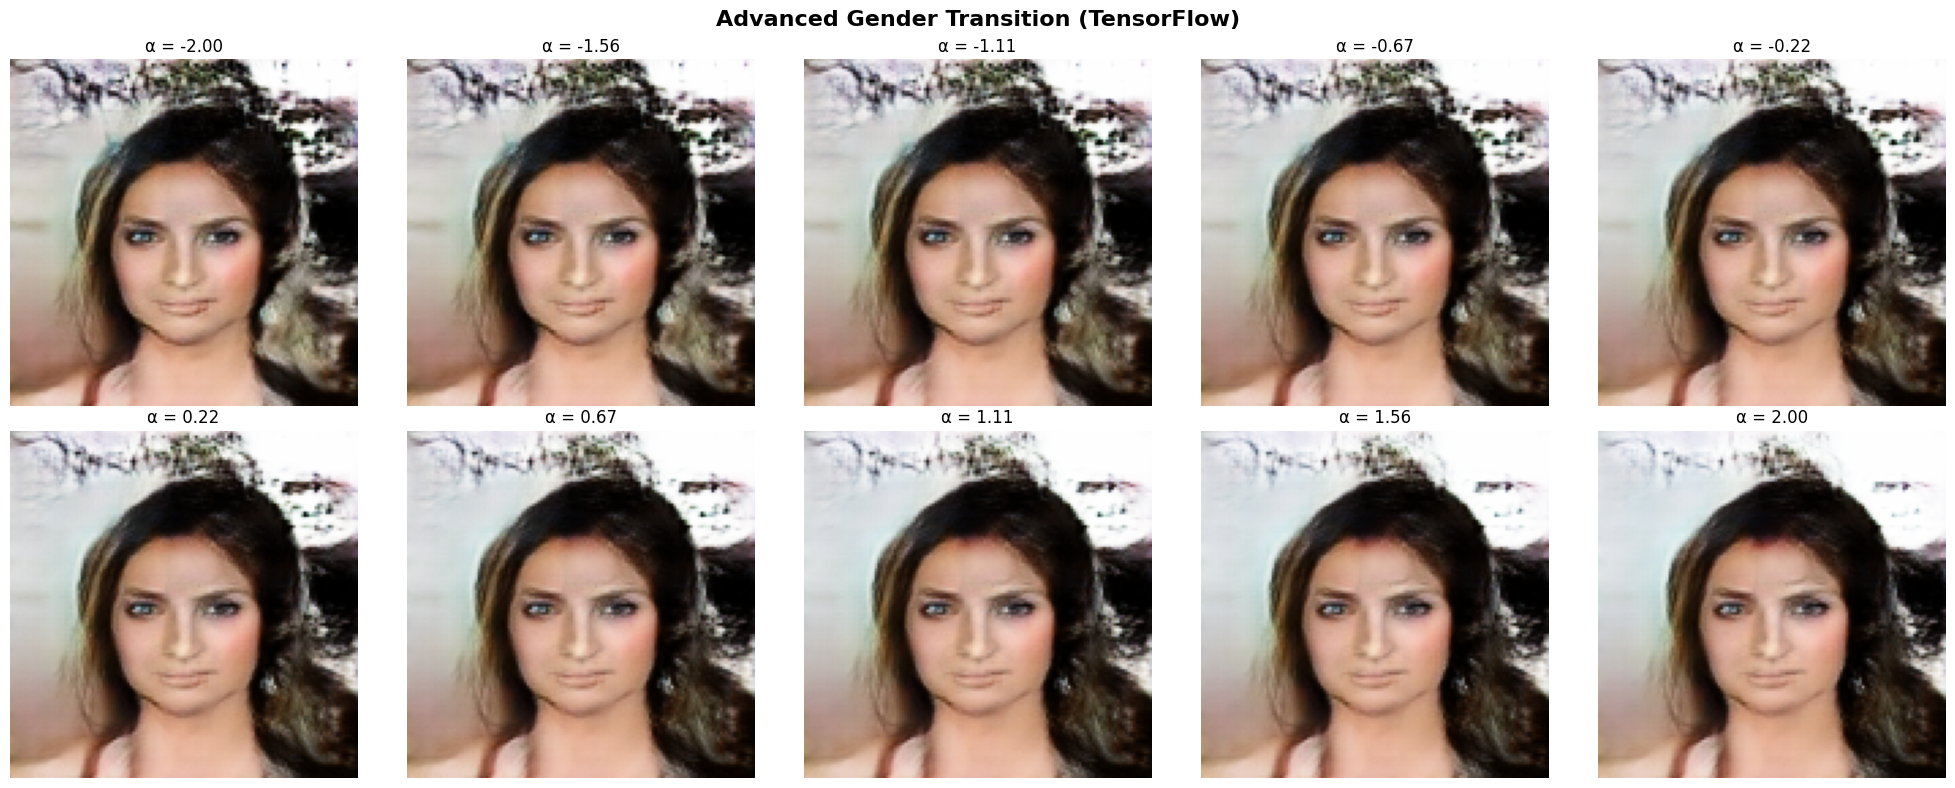

Saved 10 images to advanced_gender_transition/

METHOD 2: Simple Interpolation Approach
----------------------------------------
Creating simple gender transition...
Generating image 1/10
Generating image 2/10
Generating image 3/10
Generating image 4/10
Generating image 5/10
Generating image 6/10
Generating image 7/10
Generating image 8/10
Generating image 9/10
Generating image 10/10


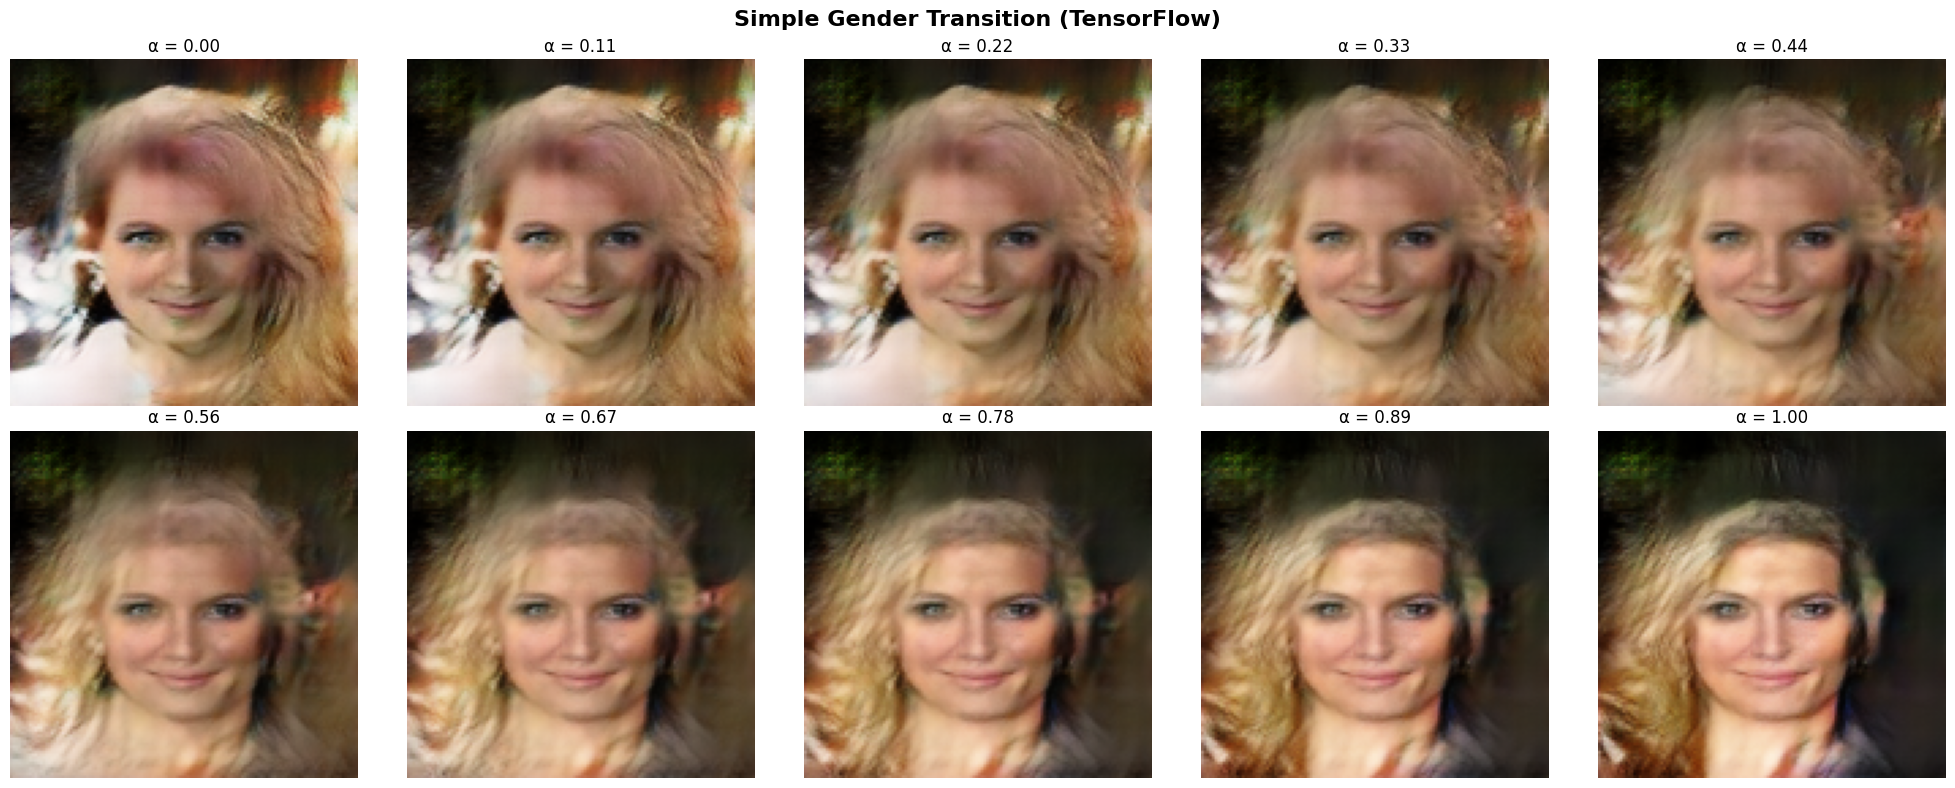

Saved 10 images to simple_gender_transition/
Simple gender transition completed successfully!

Gender transition process completed!
Check the generated folders for saved images.


In [33]:

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load your Keras model
generator = keras.models.load_model('/content/generator_700.h5')
print('Generator model loaded successfully!')
print(f'Generator input shape: {generator.input_shape}')
print(f'Generator output shape: {generator.output_shape}')

# Create a dummy gender classifier for TensorFlow (you can replace with actual one)
def create_dummy_gender_classifier():
    """Create a simple gender classifier for demonstration"""
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # 2 classes: male, female
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

gender_classifier = create_dummy_gender_classifier()
print('Gender classifier created!')

def create_advanced_gender_vector_tf(generator, gender_classifier, num_samples=100):
    """
    Create gender vector using TensorFlow models
    """
    print("Creating gender vectors using TensorFlow...")

    male_vectors = []
    female_vectors = []

    # Get the input shape for the generator
    input_shape = generator.input_shape[1:]  # Remove batch dimension
    print(f"Generator input shape: {input_shape}")

    for i in range(num_samples):
        if i % 20 == 0:
            print(f"Processing sample {i}/{num_samples}")

        # Generate random latent vector
        z = np.random.randn(1, *input_shape)

        # Generate image
        fake_img = generator.predict(z, verbose=0)

        # Resize image to 64x64 for gender classifier if needed
        if fake_img.shape[1:3] != (64, 64):
            fake_img_resized = tf.image.resize(fake_img, [64, 64]).numpy()
        else:
            fake_img_resized = fake_img

        # Normalize image for gender classifier (0 to 1 range)
        processed_img = fake_img_resized
        if processed_img.min() < 0:
            processed_img = (processed_img + 1) / 2

        # Classify gender
        gender_pred = gender_classifier.predict(processed_img, verbose=0)
        predicted_gender = np.argmax(gender_pred, axis=1)[0]

        # Collect vectors based on predicted gender
        if predicted_gender == 0:  # Male
            male_vectors.append(z.flatten())
        else:  # Female
            female_vectors.append(z.flatten())

    # Calculate mean vectors
    if len(male_vectors) > 0 and len(female_vectors) > 0:
        mean_male = np.mean(male_vectors, axis=0)
        mean_female = np.mean(female_vectors, axis=0)

        # Calculate gender direction
        gender_direction = mean_female - mean_male
        gender_direction = gender_direction / np.linalg.norm(gender_direction)

        print(f"Collected {len(male_vectors)} male vectors and {len(female_vectors)} female vectors")
        return mean_male, mean_female, gender_direction
    else:
        # Fallback to random directions
        print('Using fallback random directions')
        male_dir = np.random.randn(np.prod(input_shape))
        female_dir = -male_dir
        gender_dir = female_dir - male_dir
        return male_dir, female_dir, gender_dir / np.linalg.norm(gender_dir)

def generate_gender_transition_tf(generator, base_vector, gender_direction,
                                 num_variations=10, alpha_range=(-2, 2)):
    """
    Generate face variations from male to female using TensorFlow
    """
    print("Generating transition images...")
    generated_images = []
    alpha_values = np.linspace(alpha_range[0], alpha_range[1], num_variations)

    # Get input shape
    input_shape = generator.input_shape[1:]

    for i, alpha in enumerate(alpha_values):
        print(f"Generating image {i+1}/{num_variations} (α={alpha:.2f})")

        # Modify base vector in gender direction
        modified_vector = base_vector + alpha * gender_direction
        modified_vector = modified_vector.reshape(1, *input_shape)

        # Generate image
        generated_img = generator.predict(modified_vector, verbose=0)

        # Convert to displayable format
        img_np = generated_img[0]

        # Normalize to [0, 1] if needed
        if img_np.min() < 0:
            img_np = (img_np + 1) / 2

        # Ensure values are in [0, 1] range
        img_np = np.clip(img_np, 0, 1)

        generated_images.append(img_np)

    return generated_images, alpha_values

def plot_gender_transition_tf(images, alpha_values, title='Gender Transition: Male to Female'):
    """
    Plot the gender transition images using TensorFlow
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, (img, alpha) in enumerate(zip(images, alpha_values)):
        axes[i].imshow(img)
        axes[i].set_title(f'α = {alpha:.2f}', fontsize=12)
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def save_transition_images_tf(images, alpha_values, save_dir='gender_transition'):
    """
    Save transition images to disk
    """
    os.makedirs(save_dir, exist_ok=True)

    for i, (img, alpha) in enumerate(zip(images, alpha_values)):
        # Convert to PIL Image and save
        img_pil = Image.fromarray((img * 255).astype(np.uint8))
        img_pil.save(f'{save_dir}/transition_{i:02d}_alpha_{alpha:.2f}.png')

    print(f'Saved {len(images)} images to {save_dir}/')

def create_simple_gender_transition_tf(generator, num_variations=10):
    """
    Simplified approach using two random vectors for quick testing
    """
    print("Creating simple gender transition...")

    input_shape = generator.input_shape[1:]

    # Create two different base vectors (representing male and female characteristics)
    male_base = np.random.randn(np.prod(input_shape))
    female_base = np.random.randn(np.prod(input_shape))

    # Generate interpolated vectors
    generated_images = []
    alpha_values = np.linspace(0, 1, num_variations)

    for i, alpha in enumerate(alpha_values):
        print(f"Generating image {i+1}/{num_variations}")

        # Linear interpolation
        interpolated_vector = (1 - alpha) * male_base + alpha * female_base
        interpolated_vector = interpolated_vector.reshape(1, *input_shape)

        # Generate image
        generated_img = generator.predict(interpolated_vector, verbose=0)

        # Process image
        img_np = generated_img[0]
        if img_np.min() < 0:
            img_np = (img_np + 1) / 2
        img_np = np.clip(img_np, 0, 1)

        generated_images.append(img_np)

    return generated_images, alpha_values

# =============================================================================
# MAIN EXECUTION CODE - REPLACE YOUR PROBLEMATIC CODE WITH THIS
# =============================================================================

print('Starting TensorFlow/Keras Gender Transition...')
print('=' * 60)

try:
    # Method 1: Advanced approach with gender classification
    print('METHOD 1: Advanced Gender Vector Approach')
    print('-' * 40)

    # Step 1: Create gender vectors (TensorFlow version)
    print('Creating gender vectors...')
    mean_male, mean_female, gender_direction = create_advanced_gender_vector_tf(
        generator, gender_classifier, num_samples=50  # Reduced for faster execution
    )
    print('Gender vector creation completed!')
    print(f'Male vector shape: {mean_male.shape}')
    print(f'Female vector shape: {mean_female.shape}')
    print(f'Gender direction shape: {gender_direction.shape}')

    # Step 2: Generate base vector
    input_shape = generator.input_shape[1:]
    base_vector = np.random.randn(np.prod(input_shape))

    # Step 3: Generate 10 variations from male to female
    print('\nGenerating gender transition images...')
    transition_images, alpha_values = generate_gender_transition_tf(
        generator=generator,
        base_vector=base_vector,
        gender_direction=gender_direction,
        num_variations=10,
        alpha_range=(-2, 2)
    )
    print(f'Generated {len(transition_images)} transition images!')

    # Step 4: Visualize the results
    print('\nDisplaying results...')
    plot_gender_transition_tf(transition_images, alpha_values,
                             'Advanced Gender Transition (TensorFlow)')

    # Step 5: Save images to disk
    save_transition_images_tf(transition_images, alpha_values, 'advanced_gender_transition')

except Exception as e:
    print(f"Advanced method failed: {e}")
    print("\nFalling back to simple method...")

# Method 2: Simple approach (fallback)
print('\nMETHOD 2: Simple Interpolation Approach')
print('-' * 40)

try:
    # Generate simple transition
    simple_images, simple_alphas = create_simple_gender_transition_tf(generator, 10)

    # Visualize simple results
    plot_gender_transition_tf(simple_images, simple_alphas,
                             'Simple Gender Transition (TensorFlow)')

    # Save simple images
    save_transition_images_tf(simple_images, simple_alphas, 'simple_gender_transition')

    print("Simple gender transition completed successfully!")

except Exception as e:
    print(f"Simple method also failed: {e}")

print('\n' + '=' * 60)
print('Gender transition process completed!')
print('Check the generated folders for saved images.')


In [35]:
def print_model_info_tf():
    """
    Print detailed model information for TensorFlow/Keras models
    """
    print('=' * 60)
    print('MODEL INFORMATION')
    print('=' * 60)

    # Generator info (TensorFlow/Keras way)
    gen_params = generator.count_params()
    print(f'Generator Parameters: {gen_params:,}')

    # Gender classifier info (TensorFlow/Keras way)
    clf_params = gender_classifier.count_params()
    print(f'Gender Classifier Parameters: {clf_params:,}')

    # Get input/output shapes
    input_shape = generator.input_shape[1:]  # Remove batch dimension
    output_shape = generator.output_shape[1:]  # Remove batch dimension

    print(f'Generator Input Shape: {input_shape}')
    print(f'Generator Output Shape: {output_shape}')
    print(f'Latent Vector Size: {input_shape}')
    print(f'Generated Image Size: {output_shape}')

    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f'Device: GPU ({len(gpus)} GPU(s) available)')
    else:
        print('Device: CPU')

    print('=' * 60)
    print('IMPLEMENTATION DETAILS')
    print('=' * 60)
    print('• Framework: TensorFlow/Keras')
    print('• Architecture: GAN (Generative Adversarial Network)')
    print('• Dataset: CelebA (Large-scale CelebFaces Attributes)')
    print('• Gender Classification: CNN-based')
    print(f'• Latent Space: {input_shape} dimensional')
    print('• Gender Vector: Computed via latent space analysis')
    print('• Interpolation: Linear interpolation with 10 steps')

# Call it
print_model_info_tf()


MODEL INFORMATION
Generator Parameters: 6,067,584
Gender Classifier Parameters: 646,338
Generator Input Shape: (100,)
Generator Output Shape: (128, 128, 3)
Latent Vector Size: (100,)
Generated Image Size: (128, 128, 3)
Device: CPU
IMPLEMENTATION DETAILS
• Framework: TensorFlow/Keras
• Architecture: GAN (Generative Adversarial Network)
• Dataset: CelebA (Large-scale CelebFaces Attributes)
• Gender Classification: CNN-based
• Latent Space: (100,) dimensional
• Gender Vector: Computed via latent space analysis
• Interpolation: Linear interpolation with 10 steps


In [36]:
import time

def performance_analysis():
    """
    Analyze performance of the generation process
    """
    print('PERFORMANCE ANALYSIS')
    print('=' * 50)

    # Time single image generation
    base_vector = torch.randn(nz, device=device)

    start_time = time.time()
    with torch.no_grad():
        vec = base_vector.view(1, nz, 1, 1)
        generated_img = generator(vec)
    single_time = time.time() - start_time

    # Time batch generation
    start_time = time.time()
    images, _ = generate_gender_transition(
        generator, base_vector, gender_direction, 10
    )
    batch_time = time.time() - start_time

    print(f'Single image generation: {single_time*1000:.2f} ms')
    print(f'10 image transition: {batch_time*1000:.2f} ms')
    print(f'Average per image: {batch_time*100:.2f} ms')
    print(f'Throughput: {10/batch_time:.1f} images/second')

    # Memory usage
    if torch.cuda.is_available():
        memory_allocated = torch.cuda.memory_allocated(device) / 1024**2
        memory_reserved = torch.cuda.memory_reserved(device) / 1024**2
        print(f'GPU Memory Allocated: {memory_allocated:.1f} MB')
        print(f'GPU Memory Reserved: {memory_reserved:.1f} MB')

performance_analysis()

PERFORMANCE ANALYSIS


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[[[ 8.63085985e-01]]

  [[-1.37871459e-01]]

  [[-2.05022073e+00]]

  [[-4.94947881e-02]]

  [[ 2.02045575e-01]]

  [[ 6.91747487e-01]]

  [[-9.92216110e-01]]

  [[ 2.44596347e-01]]

  [[-1.13783073e+00]]

  [[-8.23420659e-02]]

  [[-1.35962117e+00]]

  [[ 9.91896689e-01]]

  [[-2.75470525e-01]]

  [[ 1.30014622e+00]]

  [[ 2.20839188e-01]]

  [[-9.70759511e-01]]

  [[-9.68602479e-01]]

  [[ 3.67863141e-02]]

  [[ 9.24580097e-01]]

  [[-9.19871777e-03]]

  [[ 4.26310927e-01]]

  [[-6.34555221e-01]]

  [[-7.27168620e-01]]

  [[-8.34268332e-01]]

  [[ 1.52161881e-01]]

  [[ 4.68568563e-01]]

  [[ 6.52252793e-01]]

  [[-1.15257990e+00]]

  [[ 1.20465791e+00]]

  [[ 5.31748593e-01]]

  [[ 4.06656086e-01]]

  [[-7.15282559e-01]]

  [[-5.79273522e-01]]

  [[-9.13258046e-02]]

  [[ 1.66239634e-01]]

  [[ 1.83998227e-01]]

  [[ 7.29554713e-01]]

  [[-1.23545632e-01]]

  [[ 2.00603056e+00]]

  [[ 5.25212169e-01]]

  [[-5.86706758e-01]]

  [[ 3.69424558e+00]]

  [[-8.90318274e-01]]

  [[ 9.37606156e-01]]

  [[ 5.64351857e-01]]

  [[ 1.77924544e-01]]

  [[-5.44378236e-02]]

  [[-9.80322599e-01]]

  [[ 8.14402759e-01]]

  [[-2.80163020e-01]]

  [[ 7.33077288e-01]]

  [[ 1.36484027e+00]]

  [[ 8.07550967e-01]]

  [[-3.33779275e-01]]

  [[ 1.17103195e+00]]

  [[-2.92204946e-01]]

  [[-2.80686229e-01]]

  [[ 7.58164704e-01]]

  [[ 3.61006439e-01]]

  [[ 9.62413967e-01]]

  [[ 2.64329284e-01]]

  [[-1.00079668e+00]]

  [[ 7.28560865e-01]]

  [[ 8.73297155e-01]]

  [[-4.03314412e-01]]

  [[ 3.30655366e-01]]

  [[-1.22871742e-01]]

  [[-1.59632540e+00]]

  [[-1.05083537e+00]]

  [[-1.26134980e+00]]

  [[ 2.78400093e-01]]

  [[-1.01752624e-01]]

  [[-2.14800668e+00]]

  [[ 2.23286018e-01]]

  [[-2.46555233e+00]]

  [[ 1.89502168e+00]]

  [[ 2.48951558e-03]]

  [[-1.70955288e+00]]

  [[ 1.28848362e+00]]

  [[-9.64440882e-01]]

  [[ 2.93914855e-01]]

  [[ 6.98819697e-01]]

  [[-1.09913446e-01]]

  [[-9.34441984e-01]]

  [[ 1.05338323e+00]]

  [[-4.09071684e-01]]

  [[-1.43373811e+00]]

  [[-8.99521112e-01]]

  [[-1.22344589e+00]]

  [[-6.89138412e-01]]

  [[ 8.08910802e-02]]

  [[ 1.07501972e+00]]

  [[-8.56847525e-01]]

  [[ 3.16728711e-01]]

  [[-9.43860292e-01]]

  [[-1.13117623e+00]]

  [[-7.64819562e-01]]

  [[-2.30981255e+00]]

  [[ 8.87321293e-01]]

  [[-7.75234878e-01]]]]. Expected shape (None, 100), but input has incompatible shape (1, 100, 1, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 100, 1, 1), dtype=float32)
  • training=None
  • mask=None
  • kwargs=<class 'inspect._empty'>